# OCI Vision API – Image Analysis (Beginner Notebook)

This step-by-step notebook lets you analyze images using Oracle Cloud Infrastructure Vision services. You'll upload an image to Object Storage and let OCI Vision automatically detect objects, text, faces, and classify it – all with the official SDK.

Based on `vision/oci_vision.py` script.

## 1. Setup and Requirements

- Your *sandbox.yaml* and *.env* should be set up with relevant bucket/OCI credentials
- Install required packages (run this in a terminal):
```bash
pip install oci python-dotenv envyaml
```
- Place your target image in the location you want (default is `vision/receipt.png` but you can upload any image!)

In [2]:
import os
from dotenv import load_dotenv
from envyaml import EnvYAML
from pathlib import Path
import oci
from oci.object_storage import ObjectStorageClient
load_dotenv()

True

## 2. Load OCI/Sandbox Configuration

In [ ]:
#make sure your sandbox.json file is setup for your environment. You might have to specify the full path depending on  your `cwd` 
#you can also try making your cwd ofr jupyter match your workspace python code: 
#vscopde menu -> Settings > Extensions > Jupyter > Notebook File Root
#change from ${fileDirname} to ${workspaceFolder}

SANDBOX_CONFIG_FILE = "sandbox.yaml"
DEFAULT_FILE = Path("./vision/receipt.png")

def load_config(config_path):
    try:
        return EnvYAML(config_path)
    except FileNotFoundError:
        print(f"Error: Configuration file '{config_path}' not found.")
        return None
    except Exception as e:
        print(f"Error loading config: {e}")
        return None

scfg = load_config(SANDBOX_CONFIG_FILE)
assert scfg is not None and 'oci' in scfg and 'bucket' in scfg, "Check your sandbox.yaml config!"
oci_cfg = oci.config.from_file(os.path.expanduser(scfg["oci"]["configFile"]), scfg["oci"]["profile"])
bucket_cfg = scfg["bucket"]
compartment_id = scfg["oci"]["compartment"]

## 3. Select and Display an Image

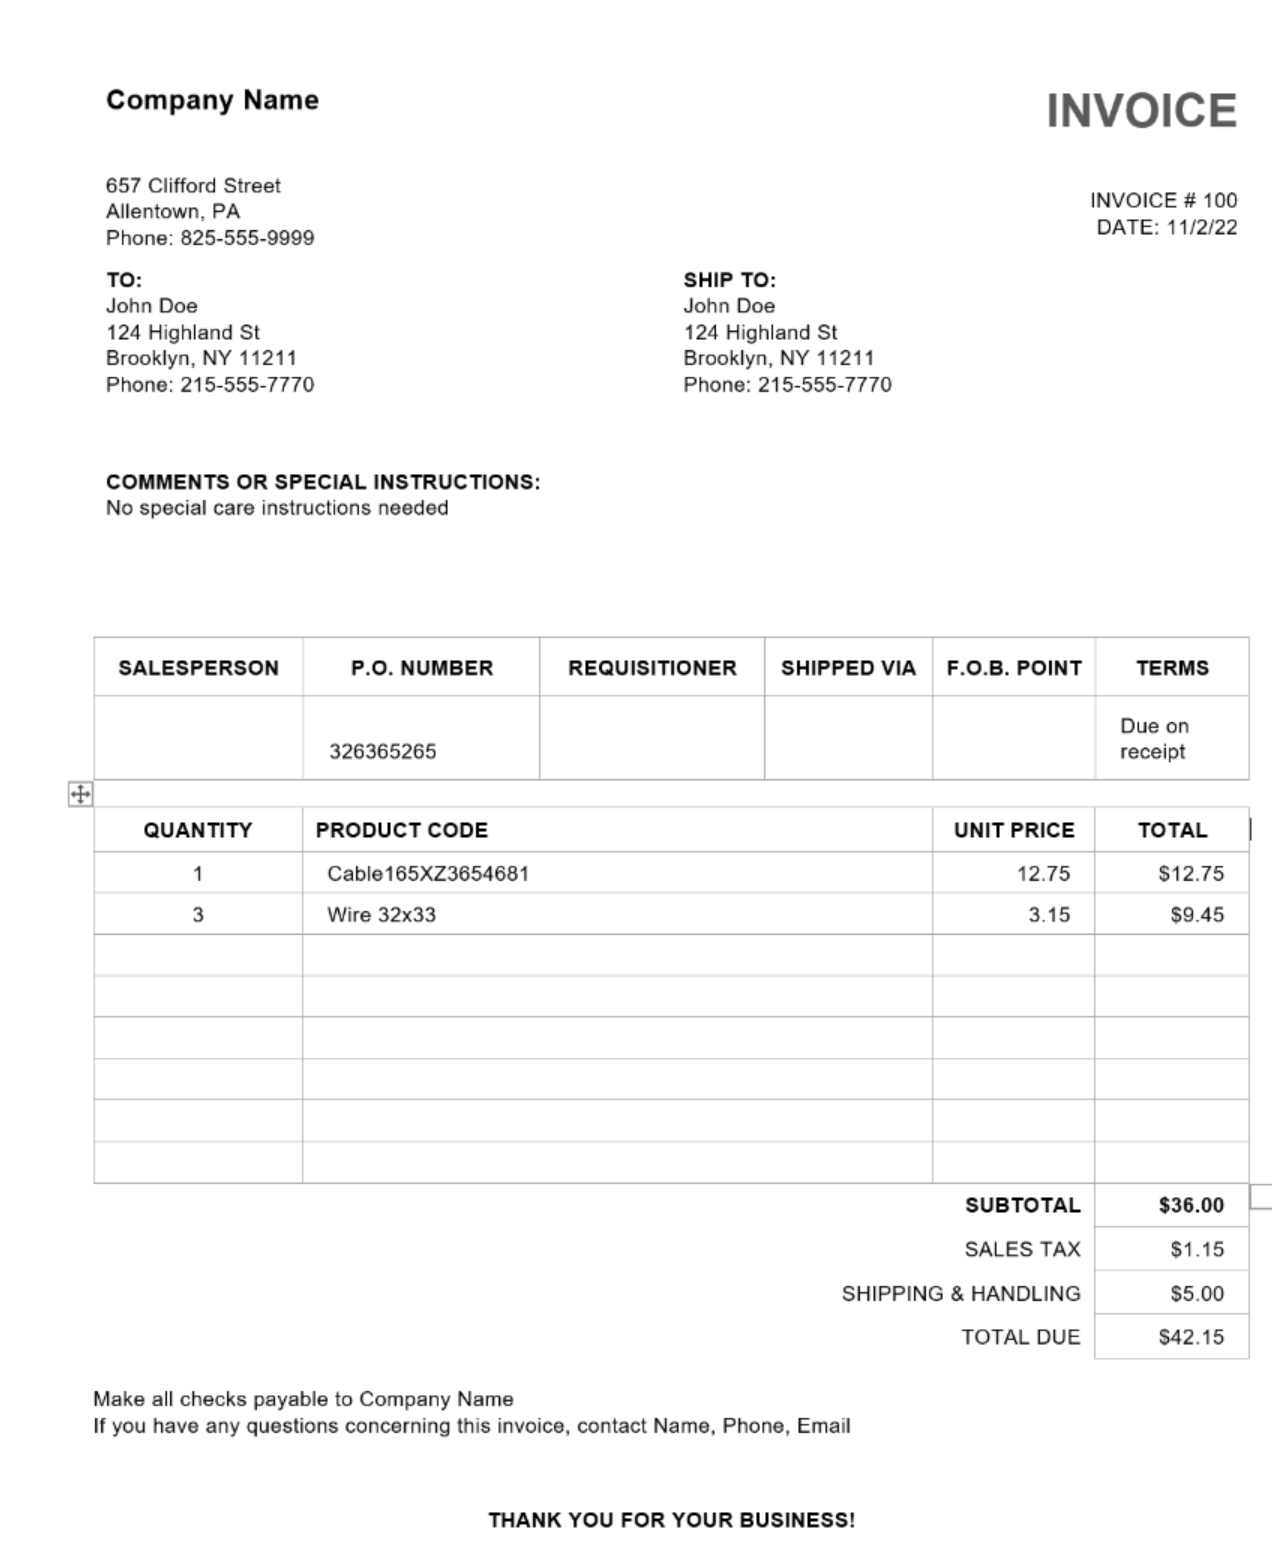

In [4]:
from IPython.display import Image, display
# Change this if you want to use another image:
FILE_PATH = Path("vision/receipt.png")
# Example: FILE_PATH = Path("vision/dussera-b.jpg")

display(Image(filename=str(FILE_PATH)))

## 4. Upload Image to OCI Object Storage

In [5]:
def upload(oci_cfg, bucket_cfg, file_path):
    if not file_path.exists():
        print(f"Error: File '{file_path}' not found.")
        return False
    object_storage_client = ObjectStorageClient(oci_cfg)
    print(f"Uploading file {file_path} ...")
    object_storage_client.put_object(
        bucket_cfg["namespace"], 
        bucket_cfg["bucketName"], 
        f"{bucket_cfg['prefix']}/{file_path.name}", 
        open(file_path, 'rb')
    )
    print("Upload completed!")
    return True

uploaded = upload(oci_cfg, bucket_cfg, FILE_PATH)
if not uploaded:
    raise ValueError("Upload failed. Check your image and configuration.")

Uploading file vision/receipt.png ...
Upload completed!


## 5. Set Up Analysis Features

In [7]:
def get_image_location(bucket_cfg, file_name):
    image = oci.ai_vision.models.ObjectStorageImageDetails(
        source="OBJECT_STORAGE",
        namespace_name=bucket_cfg["namespace"],
        bucket_name=bucket_cfg["bucketName"],
        object_name=f"{bucket_cfg['prefix']}/{file_name}"
    )
    return image

def get_analyze_image_details(features, compartment_id, bucket_cfg, file_name):
    details = oci.ai_vision.models.AnalyzeImageDetails(
        features=features,
        image=get_image_location(bucket_cfg, file_name),
        compartment_id=compartment_id
    )
    return details

features = [
    oci.ai_vision.models.ImageClassificationFeature(),
    oci.ai_vision.models.ImageObjectDetectionFeature(),
    oci.ai_vision.models.ImageTextDetectionFeature(),
    oci.ai_vision.models.FaceDetectionFeature()
]

## 6. Analyze Image!

In [8]:
vision_client = oci.ai_vision.AIServiceVisionClient(config=oci_cfg)
try:
    response = vision_client.analyze_image(
        get_analyze_image_details(features, compartment_id, bucket_cfg, FILE_PATH.name)
    )
    if response:
        print("Analysis complete! (Status: ", response.status, ")")
except Exception as e:
    print(f"Error during analysis: {e}")
    response = None

Analysis complete! (Status:  200 )


## 7. Parse and Print Results

In [9]:
def parse_vision_response(data):
    print("\nOCI Vision Analysis Results:")
    labels = getattr(data, 'labels', None)
    if labels:
        print("\nClassifications:")
        for label in labels:
            print(f"  - {label.name}: {label.confidence:.2f}")
    image_objects = getattr(data, 'image_objects', None)
    if image_objects:
        print("\nDetected Objects:")
        for obj in image_objects:
            print(f"  - {obj.name} : {obj.confidence:.2f}")
    image_text = getattr(data, 'image_text', None)
    if image_text and hasattr(image_text, 'lines'):
        print("\nDetected Text Lines:")
        for line in image_text.lines:
            print(f"  - {line.text}: {line.confidence:.2f}")
    detected_faces = getattr(data, 'detected_faces', None)
    if detected_faces:
        print("\nDetected Faces:")
        for face in detected_faces:
            print(f"  - Face confidence: {face.confidence:.2f} : Quality {face.quality_score:.2f}")
    if not any([labels, image_objects, image_text, detected_faces]):
        print("No features detected in the image.")

if response is not None and hasattr(response, 'data'):
    parse_vision_response(response.data)


OCI Vision Analysis Results:

Classifications:
  - Letter: 0.95
  - Handwriting: 0.86
  - Menu: 0.85
  - Line: 0.66
  - Text: 0.49

Detected Text Lines:
  - Company Name: 0.92
  - INVOICE: 1.00
  - 657 Clifford Street: 0.95
  - Allentown, PA: 1.00
  - INVOICE # 100: 0.96
  - Phone: 825-555-9999: 1.00
  - DATE: 11/2/22: 0.94
  - TO:: 1.00
  - SHIP TO:: 1.00
  - John Doe: 1.00
  - John Doe: 1.00
  - 124 Highland St: 1.00
  - 124 Highland St: 1.00
  - Brooklyn, NY 11211: 0.95
  - Brooklyn, NY 11211: 0.96
  - Phone: 215-555-7770: 0.91
  - Phone: 215-555-7770: 0.93
  - COMMENTS OR SPECIAL INSTRUCTIONS:: 0.96
  - No special care instructions needed: 0.95
  - SALESPERSON: 0.99
  - P.O. NUMBER: 0.97
  - REQUISITIONER: 0.99
  - SHIPPED VIA: 1.00
  - F.O.B. POINT: 0.97
  - TERMS: 0.91
  - Due on: 0.92
  - 326365265: 1.00
  - receipt: 0.99
  - +: 0.41
  - QUANTITY: 0.89
  - PRODUCT CODE: 0.93
  - UNIT PRICE: 1.00
  - TOTAL: 1.00
  - 1: 1.00
  - Cable165XZ3654681: 0.97
  - 12.75: 0.97
  - $12.75:


## 🎉 Done! Next Steps

- Try different images or text files for analysis.
- Adapt feature selection for narrower use-cases (object-detection only, for instance).
- Explore downstream automation: parse response dicts for structured results!
- project ideas: 
-     OCR a reciept
-     Identify type of document uploaded
-     confoirm ID matches the user baed on name and DOB
-     type with typed & handwritten images 

If you have OCI API errors, check your config, permissions, and credentials.